In [1]:
import os

# In ra toàn bộ file/folder trong thư mục input
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f'\n📁 Thư mục: {dirname}')
    for filename in filenames:
        print(f'  📄 File: {filename}')



📁 Thư mục: /kaggle/input

📁 Thư mục: /kaggle/input/vang-pbt
  📄 File: XAUUSD.csv


In [2]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("Warning: GPU not available, training on CPU will be slow!")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


# Phần 1: Xử lý Dữ liệu Ban đầu

Mục tiêu:

Đọc dữ liệu từ file (giả sử là CSV) và chuyển đổi thành định dạng phù hợp.

Tạo cột timestamp từ Date và Time.

Kiểm tra và xử lý giá trị thiếu (nếu có).

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Đọc dữ liệu từ file CSV
data_path = '/kaggle/input/vang-pbt/XAUUSD.csv'  # Thay bằng đường dẫn thực tế trên Kaggle
df = pd.read_csv(data_path, names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'], skiprows=1)

# Kiểm tra dữ liệu
print("Dữ liệu ban đầu:")
print(df.head())
print("\nThông tin dữ liệu:")
print(df.info())

# Tạo cột timestamp
print("\nTạo cột timestamp...")
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H:%M', errors='coerce')

# Kiểm tra và xóa các hàng có timestamp không hợp lệ
if df['timestamp'].isnull().any():
    print(f"Có {df['timestamp'].isnull().sum()} giá trị timestamp không hợp lệ. Xóa các hàng này...")
    df = df.dropna(subset=['timestamp'])

# Sắp xếp theo timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

# Kiểm tra giá trị thiếu
print("\nKiểm tra giá trị thiếu:")
print(df.isnull().sum())

# Lưu các cột cần thiết
df = df[['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']]

print("\nDữ liệu sau khi xử lý ban đầu:")
print(df.head())

Dữ liệu ban đầu:
         Date   Time   Open   High    Low  Close  Volume
0  2004.06.14  04:17  382.6  382.8  382.6  382.8       2
1  2004.06.14  04:20  382.6  382.6  382.6  382.6       1
2  2004.06.14  04:23  382.8  382.8  382.6  382.6       2
3  2004.06.14  04:26  383.1  383.1  383.1  383.1       1
4  2004.06.14  04:27  382.6  382.6  382.6  382.6       1

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6514473 entries, 0 to 6514472
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Time    object 
 2   Open    float64
 3   High    float64
 4   Low     float64
 5   Close   float64
 6   Volume  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 347.9+ MB
None

Tạo cột timestamp...

Kiểm tra giá trị thiếu:
Date         0
Time         0
Open         0
High         0
Low          0
Close        0
Volume       0
timestamp    0
dtype: int64

Dữ liệu sau khi xử lý ban đầu:
            timestamp   Open   High    

# Phần 2: Phân Chia Dữ liệu Train/Val/Test
Mục tiêu:

Chia dữ liệu thành tập train, validation, và test theo tỷ lệ thời gian (không ngẫu nhiên để tránh rò rỉ dữ liệu).

Đảm bảo không có rò rỉ dữ liệu từ tương lai (như trong bài ví dụ đã cảnh báo).

In [4]:
# Tính toán số lượng hàng cho từng tập
total_rows = len(df)
train_size = int(0.70 * total_rows)
val_size = int(0.15 * total_rows)
test_size = total_rows - train_size - val_size

# Chia dữ liệu
train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Kiểm tra kích thước
print("\nKích thước các tập dữ liệu:")
print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Kiểm tra khoảng thời gian
print("\nKhoảng thời gian của các tập:")
print(f"Train: từ {train_df['timestamp'].min()} đến {train_df['timestamp'].max()}")
print(f"Validation: từ {val_df['timestamp'].min()} đến {val_df['timestamp'].max()}")
print(f"Test: từ {test_df['timestamp'].min()} đến {test_df['timestamp'].max()}")


Kích thước các tập dữ liệu:
Train: (4560131, 6)
Validation: (977170, 6)
Test: (977172, 6)

Khoảng thời gian của các tập:
Train: từ 2004-06-14 04:17:00 đến 2019-08-22 16:59:00
Validation: từ 2019-08-22 17:00:00 đến 2022-06-07 00:34:00
Test: từ 2022-06-07 00:35:00 đến 2025-03-11 07:15:00


# Phần 3: Gán Nhãn (Labeling) cho Dữ liệu

**Mục tiêu:**

Gán nhãn BUY, SELL, HOLD dựa trên biến động giá trong tương lai (tương tự bài ví dụ).

Chỉ áp dụng cho train và validation để tránh rò rỉ dữ liệu.

**Logic gán nhãn:**
So sánh giá Close hiện tại với giá Close sau 30 phút.

Ngưỡng thay đổi giá: ±0.05% (có thể điều chỉnh).

Nhãn:

BUY: Giá tăng > 0.05%

SELL: Giá giảm > 0.05%

HOLD: Giá thay đổi trong khoảng ±0.05%

In [5]:
from tqdm.notebook import tqdm

def add_labels(df, delta_minutes=30, threshold=0.0005): # có thể điều chỉnh delta và threshold tùy bài toán.
    """
    Gán nhãn BUY, SELL, HOLD dựa trên biến động giá tương lai.
    """
    print("Áp dụng hàm add_labels...")
    df = df.sort_values('timestamp').reset_index(drop=True)
    future_closes = df['Close'].shift(-delta_minutes)
    labels = []

    print(f"Tạo nhãn dựa trên giá sau {delta_minutes} phút...")
    for idx in tqdm(range(len(df)), desc="Tạo nhãn"):
        current_close = df.loc[idx, 'Close']
        future_close = future_closes.loc[idx]
        if pd.isna(future_close):
            labels.append('HOLD')
        elif future_close > current_close * (1 + threshold):
            labels.append('BUY')
        elif future_close < current_close * (1 - threshold):
            labels.append('SELL')
        else:
            labels.append('HOLD')

    df['Label'] = labels
    print("Hoàn thành gán nhãn.")
    print("Phân bố nhãn (%):")
    print(df['Label'].value_counts(normalize=True) * 100)
    return df

# Áp dụng gán nhãn cho train và validation
print("\n--- Gán nhãn cho Train và Validation ---")
train_labeled = add_labels(train_df)
val_labeled = add_labels(val_df)

# Tập test không gán nhãn ở bước này để tránh rò rỉ dữ liệu
# test_labeled = test_df.copy()  # Giữ nguyên, sẽ xử lý sau nếu cần
test_labeled = add_labels(test_df)


--- Gán nhãn cho Train và Validation ---
Áp dụng hàm add_labels...
Tạo nhãn dựa trên giá sau 30 phút...


Tạo nhãn:   0%|          | 0/4560131 [00:00<?, ?it/s]

Hoàn thành gán nhãn.
Phân bố nhãn (%):
Label
HOLD    40.946236
BUY     29.966266
SELL    29.087498
Name: proportion, dtype: float64
Áp dụng hàm add_labels...
Tạo nhãn dựa trên giá sau 30 phút...


Tạo nhãn:   0%|          | 0/977170 [00:00<?, ?it/s]

Hoàn thành gán nhãn.
Phân bố nhãn (%):
Label
HOLD    42.755918
BUY     29.453524
SELL    27.790558
Name: proportion, dtype: float64
Áp dụng hàm add_labels...
Tạo nhãn dựa trên giá sau 30 phút...


Tạo nhãn:   0%|          | 0/977172 [00:00<?, ?it/s]

Hoàn thành gán nhãn.
Phân bố nhãn (%):
Label
HOLD    46.080833
BUY     27.525553
SELL    26.393613
Name: proportion, dtype: float64


# Phần 4: Thêm Các Chỉ Báo Kỹ Thuật (Technical Indicators)

**Mục tiêu:**

Thêm các chỉ báo kỹ thuật (TA) để tăng thông tin đầu vào cho mô hình.

Sử dụng thư viện ta như trong bài ví dụ.

**Các chỉ báo:**

Sử dụng danh sách chỉ báo từ bài ví dụ, bao gồm:

Momentum: RSI, Momentum, CMO, Williams %R

Volatility: ATR, Bollinger Bands, Keltner Channel, Donchian Channel

Trend: SMA, EMA, DPO, MACD, Mass Index

Volume: AD, CMF, Force Index, MFI, OBV

In [6]:
!pip install ta  # Cài đặt thư viện ta trên Kaggle

import ta

def add_all_indicators(df):
    """Thêm các chỉ báo kỹ thuật."""
    print("Thêm các chỉ báo kỹ thuật...")
    # Momentum
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['Momentum'] = ta.momentum.ROCIndicator(df['Close']).roc()
    df['CMO'] = ta.momentum.kama(df['Close'])
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
    # Volatility
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Mid'] = bb.bollinger_mavg()
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Bandwidth'] = bb.bollinger_wband()
    keltner = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'])
    df['KC_High'] = keltner.keltner_channel_hband()
    df['KC_Low'] = keltner.keltner_channel_lband()
    donchian = ta.volatility.DonchianChannel(df['High'], df['Low'], df['Close'])
    df['DC_High'] = donchian.donchian_channel_hband()
    df['DC_Low'] = donchian.donchian_channel_lband()
    # Trend
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['DPO'] = ta.trend.DPOIndicator(df['Close']).dpo()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Hist'] = macd.macd_diff()
    df['Mass_Index'] = ta.trend.mass_index(df['High'], df['Low'])
    # Volume
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()
    df['Force_Index'] = ta.volume.ForceIndexIndicator(df['Close'], df['Volume']).force_index()
    df['MFI'] = ta.volume.MFIIndicator(df['High'], df['Low'], df['Close'], df['Volume']).money_flow_index()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    # Xử lý NaN
    print("Xử lý giá trị NaN...")
    n_nan_before = df.isnull().sum().sum()
    df = df.bfill().ffill()
    n_nan_after = df.isnull().sum().sum()
    print(f"NaN trước khi xử lý: {n_nan_before}, NaN sau khi xử lý: {n_nan_after}")
    if n_nan_after > 0:
        print(f"Cảnh báo: Còn {n_nan_after} NaN. Xóa các hàng này...")
        df = df.dropna()

    print("Hoàn thành thêm chỉ báo.")
    return df.reset_index(drop=True)

# Áp dụng cho các tập dữ liệu
print("\n--- Thêm chỉ báo kỹ thuật ---")
train_with_ta = add_all_indicators(train_labeled)
val_with_ta = add_all_indicators(val_labeled)
test_with_ta = add_all_indicators(test_labeled)

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e8ff59837294ffda4d720628781cdf1ccf326f245ecc4a65c4b92ad8513ba51b
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta

--- Thêm chỉ báo kỹ thuật ---
Thêm các chỉ báo kỹ thuật...
Xử lý giá trị NaN...
NaN trước khi xử lý: 905, NaN sau khi xử lý: 0
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Xử lý giá trị NaN...
NaN trước khi xử lý: 361, NaN sau khi xử lý: 0
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Xử lý giá trị NaN...
NaN trước khi xử lý: 361, NaN sau khi xử lý: 0
Hoàn thành thêm chỉ báo.


In [7]:
test_with_ta.head()


,timestamp,Open,High,Low,Close,Volume,Label,RSI,Momentum,CMO,...,EMA_20,DPO,MACD,MACD_Hist,Mass_Index,AD,CMF,Force_Index,MFI,OBV
0,2022-06-07 00:35:00,1838.89,1839.11,1838.89,1839.02,44,HOLD,53.191806,-0.018488,1838.73,...,1839.009311,-0.6315,0.120925,-0.042,23.233881,8.000000,-0.02787,0.796024,55.6315,44
1,2022-06-07 00:36:00,1839.12,1839.13,1839.05,1839.09,20,HOLD,53.191806,-0.018488,1838.73,...,1839.009311,-0.6315,0.120925,-0.042,23.233881,8.000000,-0.02787,0.796024,55.6315,64
2,2022-06-07 00:37:00,1839.08,1839.08,1838.86,1839.02,31,HOLD,53.191806,-0.018488,1838.73,...,1839.009311,-0.6315,0.120925,-0.042,23.233881,22.090909,-0.02787,0.796024,55.6315,33
3,2022-06-07 00:38:00,1838.93,1839.02,1838.76,1838.90,27,HOLD,53.191806,-0.018488,1838.73,...,1839.009311,-0.6315,0.120925,-0.042,23.233881,24.167832,-0.02787,0.796024,55.6315,6
4,2022-06-07 00:39:00,1838.92,1839.11,1838.92,1838.97,27,HOLD,53.191806,-0.018488,1838.73,...,1839.009311,-0.6315,0.120925,-0.042,23.233881,11.378358,-0.02787,0.796024,55.6315,33


# Phần 5: Tiền Xử lý Cuối (Preprocessing)

**Mục tiêu:**

Chuẩn hóa dữ liệu (e.g., tính phần trăm thay đổi, chuẩn hóa đặc trưng).

Thêm đặc trưng thời gian (time features).

Ánh xạ nhãn thành số (BUY: 0, SELL: 1, HOLD: 2).

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def preprocessing(df):
    """Tiền xử lý cuối: pct_change, ánh xạ nhãn, thêm đặc trưng thời gian."""
    print("Áp dụng tiền xử lý...")
    # Tính phần trăm thay đổi cho OHLC
    cols_to_pct = ['Open', 'High', 'Low', 'Close']
    existing_cols = [col for col in cols_to_pct if col in df.columns]
    if existing_cols:
        print(f"Tính phần trăm thay đổi cho: {existing_cols}")
        df[existing_cols] = df[existing_cols].pct_change().fillna(0) * 100
    else:
        print("Cảnh báo: Không tìm thấy cột OHLC để tính pct_change.")

    # Ánh xạ nhãn
    label_map = {"BUY": 0, "SELL": 1, "HOLD": 2}
    print(f"Sử dụng ánh xạ nhãn: {label_map}")
    if 'Label' in df.columns:
        print(f"Nhãn gốc: {df['Label'].unique()}")
        df['Label'] = df['Label'].map(label_map)
        if df['Label'].isnull().any():
            print(f"Cảnh báo: Có {df['Label'].isnull().sum()} nhãn NaN. Xóa các hàng này...")
            df = df.dropna(subset=['Label'])
        df['Label'] = df['Label'].astype(int)
    else:
        print("Cảnh báo: Không tìm thấy cột 'Label'.")

    # Thêm đặc trưng thời gian
    if 'timestamp' in df.columns:
        print("Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...")
        df['hour'] = df['timestamp'].dt.hour / 23.0 #(chuẩn hóa về [0,1]).
        df['day_of_week'] = df['timestamp'].dt.dayofweek / 6.0
        df['minute_of_day'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) / 1439.0
        df['index'] = np.arange(len(df)) / (len(df) - 1 if len(df) > 1 else 1)
        df = df.drop(columns=['timestamp'], errors='ignore')
    else:
        print("Cảnh báo: Không thể tạo đặc trưng thời gian do thiếu cột 'timestamp'.")

    print("Hoàn thành tiền xử lý.")
    return df.reset_index(drop=True)

# Áp dụng tiền xử lý
print("\n--- Áp dụng tiền xử lý ---")
train_processed = preprocessing(train_with_ta)
val_processed = preprocessing(val_with_ta)
test_processed = preprocessing(test_with_ta)  # Test vẫn xử lý, nhưng nhãn sẽ được xử lý riêng nếu cần


--- Áp dụng tiền xử lý ---
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Sử dụng ánh xạ nhãn: {'BUY': 0, 'SELL': 1, 'HOLD': 2}
Nhãn gốc: ['BUY' 'HOLD' 'SELL']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Sử dụng ánh xạ nhãn: {'BUY': 0, 'SELL': 1, 'HOLD': 2}
Nhãn gốc: ['SELL' 'HOLD' 'BUY']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Sử dụng ánh xạ nhãn: {'BUY': 0, 'SELL': 1, 'HOLD': 2}
Nhãn gốc: ['HOLD' 'BUY' 'SELL']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.


In [9]:
test_processed.head()

,Open,High,Low,Close,Volume,Label,RSI,Momentum,CMO,Williams_%R,...,Mass_Index,AD,CMF,Force_Index,MFI,OBV,hour,day_of_week,minute_of_day,index
0,0.000000,0.000000,0.000000,0.000000,44,2,53.191806,-0.018488,1838.73,-23.870968,...,23.233881,8.000000,-0.02787,0.796024,55.6315,44,0.0,0.166667,0.024322,0.000000
1,0.012508,0.001087,0.008701,0.003806,20,2,53.191806,-0.018488,1838.73,-23.870968,...,23.233881,8.000000,-0.02787,0.796024,55.6315,64,0.0,0.166667,0.025017,0.000001
2,-0.002175,-0.002719,-0.010331,-0.003806,31,2,53.191806,-0.018488,1838.73,-23.870968,...,23.233881,22.090909,-0.02787,0.796024,55.6315,33,0.0,0.166667,0.025712,0.000002
3,-0.008156,-0.003263,-0.005438,-0.006525,27,2,53.191806,-0.018488,1838.73,-23.870968,...,23.233881,24.167832,-0.02787,0.796024,55.6315,6,0.0,0.166667,0.026407,0.000003
4,-0.000544,0.004894,0.008702,0.003807,27,2,53.191806,-0.018488,1838.73,-23.870968,...,23.233881,11.378358,-0.02787,0.796024,55.6315,33,0.0,0.166667,0.027102,0.000004


In [10]:
train_processed.head()

,Open,High,Low,Close,Volume,Label,RSI,Momentum,CMO,Williams_%R,...,Mass_Index,AD,CMF,Force_Index,MFI,OBV,hour,day_of_week,minute_of_day,index
0,0.000000,0.000000,0.000000,0.000000,2,0,51.296441,0.0,382.5,-50.0,...,20.836749,2.0,0.0,-0.015863,42.871896,2,0.173913,0.0,0.178596,0.000000e+00
1,0.000000,-0.052247,0.000000,-0.052247,1,2,51.296441,0.0,382.5,-50.0,...,20.836749,2.0,0.0,-0.015863,42.871896,1,0.173913,0.0,0.180681,2.192920e-07
2,0.052274,0.052274,0.000000,0.000000,2,2,51.296441,0.0,382.5,-50.0,...,20.836749,0.0,0.0,-0.015863,42.871896,3,0.173913,0.0,0.182766,4.385840e-07
3,0.078370,0.078370,0.130685,0.130685,1,1,51.296441,0.0,382.5,-50.0,...,20.836749,0.0,0.0,-0.015863,42.871896,4,0.173913,0.0,0.184851,6.578760e-07
4,-0.130514,-0.130514,-0.130514,-0.130514,1,2,51.296441,0.0,382.5,-50.0,...,20.836749,0.0,0.0,-0.015863,42.871896,3,0.173913,0.0,0.185546,8.771680e-07


# Phần 6: Chuẩn hóa Dữ liệu theo Khối (Block Normalization)

**Mục tiêu:**

Chuẩn hóa dữ liệu theo các khối (block) để phù hợp với mô hình Transformer, như trong bài ví dụ.

Đảm bảo các đặc trưng có giá trị trong cùng một phạm vi (thường là mean=0, std=1) để cải thiện hiệu quả huấn luyện.

**Phương pháp:**

Sử dụng hàm normalize_by_blocks từ bài ví dụ, chuẩn hóa dữ liệu theo các khối có kích thước bằng sequence_length (e.g., 64).

Áp dụng StandardScaler cho từng khối để tránh rò rỉ thông tin giữa các khối.

In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def normalize_by_blocks(data, block_size):
    print(f"Áp dụng normalize_by_blocks với block_size={block_size}...")
    if isinstance(data, pd.DataFrame):
        columns = data.columns
        index = data.index
        data_np = data.values.astype('float32')
    else:
        data_np = data.astype('float32')
        columns = None
        index = None

    result = np.zeros_like(data_np)
    num_blocks = 0

    for start_idx in range(0, len(data_np), block_size):
        end_idx = min(start_idx + block_size, len(data_np))
        block = data_np[start_idx:end_idx]

        if block.shape[0] > 0:
            scaler = StandardScaler()
            if block.shape[0] == 1:
                normalized_block = block - np.mean(block, axis=0)
            else:
                std_devs = np.std(block, axis=0)
                if np.any(std_devs == 0):
                    normalized_block = np.zeros_like(block)
                    valid_cols = std_devs != 0
                    if np.any(valid_cols):
                        scaler.fit(block[:, valid_cols])
                        normalized_block[:, valid_cols] = scaler.transform(block[:, valid_cols])
                    zero_std_cols = std_devs == 0
                    if np.any(zero_std_cols):
                        normalized_block[:, zero_std_cols] = block[:, zero_std_cols] - np.mean(block[:, zero_std_cols], axis=0)
                else:
                    normalized_block = scaler.fit_transform(block)

            if np.isnan(normalized_block).any() or np.isinf(normalized_block).any():
                normalized_block = np.nan_to_num(normalized_block, nan=0.0, posinf=0.0, neginf=0.0)

            result[start_idx:end_idx] = normalized_block
            num_blocks += 1

    print(f"Hoàn thành normalize_by_blocks. Đã xử lý {num_blocks} khối.")
    if columns is not None and index is not None:
        return pd.DataFrame(result, columns=columns, index=index)
    else:
        return result

# Định nghĩa các cột đặc trưng
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'RSI', 'Momentum', 'CMO', 'Williams_%R',
    'ATR', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'BB_Bandwidth',
    'KC_High', 'KC_Low', 'DC_High', 'DC_Low',
    'SMA_20', 'EMA_20', 'DPO', 'MACD', 'MACD_Hist', 'Mass_Index',
    'AD', 'CMF', 'Force_Index', 'MFI', 'OBV',
    'index', 'hour', 'day_of_week', 'minute_of_day'
]

# Lọc các cột có trong dữ liệu
feature_cols = [col for col in feature_cols if col in train_processed.columns]
print(f"Sử dụng {len(feature_cols)} cột đặc trưng: {feature_cols}")

# Áp dụng chuẩn hóa theo khối
SEQ_LEN = 128  # Độ dài chuỗi 
print("\n--- Áp dụng chuẩn hóa theo khối ---")
train_final = train_processed.copy()
val_final = val_processed.copy()
test_final = test_processed.copy()

train_final[feature_cols] = normalize_by_blocks(train_processed[feature_cols], SEQ_LEN)
val_final[feature_cols] = normalize_by_blocks(val_processed[feature_cols], SEQ_LEN)
test_final[feature_cols] = normalize_by_blocks(test_processed[feature_cols], SEQ_LEN)

print("Chuẩn hóa theo khối hoàn tất.")

Sử dụng 33 cột đặc trưng: ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Momentum', 'CMO', 'Williams_%R', 'ATR', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'BB_Bandwidth', 'KC_High', 'KC_Low', 'DC_High', 'DC_Low', 'SMA_20', 'EMA_20', 'DPO', 'MACD', 'MACD_Hist', 'Mass_Index', 'AD', 'CMF', 'Force_Index', 'MFI', 'OBV', 'index', 'hour', 'day_of_week', 'minute_of_day']

--- Áp dụng chuẩn hóa theo khối ---
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 35627 khối.
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 7635 khối.
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 7635 khối.
Chuẩn hóa theo khối hoàn tất.


# Phần 7: Tạo Dataset và DataLoader
**Mục tiêu:**

Tạo Dataset tùy chỉnh để quản lý dữ liệu chuỗi cho Transformer.

Sử dụng DataLoader để tải dữ liệu theo batch.

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class PreprocessedStockDataset(Dataset):
    def __init__(self, df, sequence_length, feature_cols, use_time2vec=True):
        self.sequence_length = sequence_length
        self.feature_cols = [col for col in feature_cols if col in df.columns]
        self.use_time2vec = use_time2vec
        self.has_time_input = False

        print(f"Khởi tạo PreprocessedStockDataset với {len(self.feature_cols)} đặc trưng.")
        if self.use_time2vec:
            if "minute_of_day" in df.columns and pd.api.types.is_numeric_dtype(df['minute_of_day']):
                print("Sử dụng 'minute_of_day' cho Time2Vec.")
                self.time_features = df["minute_of_day"].values[:, np.newaxis].astype(np.float32)
                self.has_time_input = True
            else:
                print("Cảnh báo: Không tìm thấy 'minute_of_day'. Time2Vec sẽ dùng giá trị 0.")
                self.time_features = np.zeros((len(df), 1), dtype=np.float32)
        else:
            self.time_features = np.zeros((len(df), 1), dtype=np.float32)

        self.features = df[self.feature_cols].values.astype(np.float32)
        if 'Label' in df.columns and pd.api.types.is_numeric_dtype(df['Label']):
            self.labels = df['Label'].values.astype(np.int64)
            print(f"Kích thước - Features: {self.features.shape}, Labels: {self.labels.shape}, Time: {self.time_features.shape}")
        else:
            print("Cảnh báo: Không tìm thấy cột 'Label'. Tạo nhãn giả (0).")
            self.labels = np.zeros(len(df), dtype=np.int64)

        if len(self.features) <= self.sequence_length:
            raise ValueError(f"Độ dài DataFrame ({len(self.features)}) phải lớn hơn sequence_length ({self.sequence_length}).")

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        end_idx = idx + self.sequence_length
        feat_seq = self.features[idx:end_idx]
        time_seq = self.time_features[idx:end_idx]
        label = self.labels[end_idx]
        return torch.from_numpy(feat_seq).float(), torch.from_numpy(time_seq).float(), torch.tensor(label).long()

# Tạo Dataset
USE_TIME2VEC = True
print("\n--- Tạo Dataset và DataLoader ---")
train_set = PreprocessedStockDataset(train_final, SEQ_LEN, feature_cols, use_time2vec=USE_TIME2VEC)
val_set = PreprocessedStockDataset(val_final, SEQ_LEN, feature_cols, use_time2vec=USE_TIME2VEC)
test_set = PreprocessedStockDataset(test_final, SEQ_LEN, feature_cols, use_time2vec=USE_TIME2VEC)

# Tạo DataLoader
BATCH_SIZE = 512
# train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
# val_loader = DataLoader(val_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
# test_loader = DataLoader(test_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print("DataLoader đã sẵn sàng.")


--- Tạo Dataset và DataLoader ---
Khởi tạo PreprocessedStockDataset với 33 đặc trưng.
Sử dụng 'minute_of_day' cho Time2Vec.
Kích thước - Features: (4560131, 33), Labels: (4560131,), Time: (4560131, 1)
Khởi tạo PreprocessedStockDataset với 33 đặc trưng.
Sử dụng 'minute_of_day' cho Time2Vec.
Kích thước - Features: (977170, 33), Labels: (977170,), Time: (977170, 1)
Khởi tạo PreprocessedStockDataset với 33 đặc trưng.
Sử dụng 'minute_of_day' cho Time2Vec.
Kích thước - Features: (977172, 33), Labels: (977172,), Time: (977172, 1)
DataLoader đã sẵn sàng.


# Phần 8: Xây dựng Mô hình Transformer với Time2Vec

**Mục tiêu:**

Triển khai mô hình Transformer với lớp Time2Vec để mã hóa đặc trưng thời gian (minute_of_day).

Mô hình dự đoán nhãn phân loại (BUY: 0, SELL: 1, HOLD: 2).

**Cấu trúc mô hình:**

Time2Vec: Mã hóa đặc trưng thời gian thành vector.

Transformer Encoder: Xử lý chuỗi dữ liệu (kết hợp đặc trưng giá và Time2Vec).

MLP Head: Dự đoán nhãn cuối.

In [13]:
import torch
import torch.nn as nn
import math

class Time2Vec(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Time2Vec, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(input_dim, 1)
        self.periodic = nn.Linear(input_dim, hidden_dim - 1)

    def forward(self, x):
        linear_part = self.linear(x)
        periodic_part = torch.sin(self.periodic(x))
        return torch.cat([linear_part, periodic_part], dim=-1)

class TransformerModel(nn.Module):
    def __init__(self, feature_dim, time_dim, seq_len, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1, num_classes=3):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # Time2Vec
        self.time2vec = Time2Vec(time_dim, d_model // 2)
        self.feature_projection = nn.Linear(feature_dim, d_model // 2)

        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.dropout = nn.Dropout(dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output Layer
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src, time_input):
        # src: (batch, seq_len, feature_dim)
        # time_input: (batch, seq_len, time_dim)
        batch_size = src.size(0)

        # Time2Vec embedding
        time_embed = self.time2vec(time_input)  # (batch, seq_len, d_model // 2)

        # Feature projection
        feat_embed = self.feature_projection(src)  # (batch, seq_len, d_model // 2)

        # Combine
        combined = torch.cat([feat_embed, time_embed], dim=-1)  # (batch, seq_len, d_model)

        # Add positional encoding
        combined = combined + self.pos_encoder[:, :self.seq_len, :].to(combined.device)
        combined = self.dropout(combined)

        # Transformer
        output = self.transformer_encoder(combined)  # (batch, seq_len, d_model)

        # Take the last timestep
        output = output[:, -1, :]  # (batch, d_model)

        # Classification
        logits = self.fc(output)  # (batch, num_classes)
        return logits

# Khởi tạo mô hình
FEATURE_DIM = len(feature_cols)
TIME_DIM = 1  # minute_of_day
SEQ_LEN = 128
D_MODEL = 32 # 64
NHEAD = 4
NUM_LAYERS = 1 # 2
DIM_FEEDFORWARD = 128 #  256
DROPOUT = 0.3
NUM_CLASSES = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("Warning: GPU not available, training on CPU will be slow!")
print(f"Sử dụng thiết bị: {device}")

model = TransformerModel(
    feature_dim=FEATURE_DIM,
    time_dim=TIME_DIM,
    seq_len=SEQ_LEN,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES
).to(device)

print("Mô hình đã được khởi tạo.")

Sử dụng thiết bị: cuda
Mô hình đã được khởi tạo.


# Phần 9: Huấn luyện Mô hình
**Mục tiêu:**

Huấn luyện mô hình với loss function và optimizer.

Sử dụng early stopping và lưu model tốt nhất (best_model.pth). 


--- Bắt đầu huấn luyện ---
Epoch 1 - RAM usage: 29.8%
VRAM usage: 0.00 GB


Epoch 1/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 1/40: Train Loss: 0.8065, Val Loss: 0.7459, Val Acc: 0.6437, Val F1: 0.6447
Saved best model to /kaggle/working/best_model.pth
Epoch 2 - RAM usage: 31.4%
VRAM usage: 0.02 GB


Epoch 2/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 2/40: Train Loss: 0.7822, Val Loss: 0.7415, Val Acc: 0.6468, Val F1: 0.6477
Saved best model to /kaggle/working/best_model.pth
Epoch 3 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 3/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 3/40: Train Loss: 0.7753, Val Loss: 0.7406, Val Acc: 0.6473, Val F1: 0.6482
Saved best model to /kaggle/working/best_model.pth
Epoch 4 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 4/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 4/40: Train Loss: 0.7724, Val Loss: 0.7511, Val Acc: 0.6401, Val F1: 0.6390
Epoch 5 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 5/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 5/40: Train Loss: 0.7706, Val Loss: 0.7489, Val Acc: 0.6454, Val F1: 0.6454
Epoch 6 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 6/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 6/40: Train Loss: 0.7693, Val Loss: 0.7515, Val Acc: 0.6416, Val F1: 0.6397
Epoch 7 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 7/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 7/40: Train Loss: 0.7639, Val Loss: 0.7431, Val Acc: 0.6481, Val F1: 0.6476
Epoch 8 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 8/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 8/40: Train Loss: 0.7629, Val Loss: 0.7393, Val Acc: 0.6499, Val F1: 0.6498
Saved best model to /kaggle/working/best_model.pth
Epoch 9 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 9/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 9/40: Train Loss: 0.7630, Val Loss: 0.7419, Val Acc: 0.6490, Val F1: 0.6488
Epoch 10 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 10/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 10/40: Train Loss: 0.7626, Val Loss: 0.7404, Val Acc: 0.6500, Val F1: 0.6500
Epoch 11 - RAM usage: 30.7%
VRAM usage: 0.02 GB


Epoch 11/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 11/40: Train Loss: 0.7624, Val Loss: 0.7407, Val Acc: 0.6499, Val F1: 0.6498
Epoch 12 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 12/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 12/40: Train Loss: 0.7619, Val Loss: 0.7390, Val Acc: 0.6504, Val F1: 0.6503
Saved best model to /kaggle/working/best_model.pth
Epoch 13 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 13/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 13/40: Train Loss: 0.7618, Val Loss: 0.7388, Val Acc: 0.6505, Val F1: 0.6506
Saved best model to /kaggle/working/best_model.pth
Epoch 14 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 14/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 14/40: Train Loss: 0.7615, Val Loss: 0.7382, Val Acc: 0.6505, Val F1: 0.6505
Saved best model to /kaggle/working/best_model.pth
Epoch 15 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 15/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 15/40: Train Loss: 0.7617, Val Loss: 0.7392, Val Acc: 0.6501, Val F1: 0.6499
Epoch 16 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 16/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 16/40: Train Loss: 0.7614, Val Loss: 0.7386, Val Acc: 0.6506, Val F1: 0.6505
Epoch 17 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 17/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 17/40: Train Loss: 0.7616, Val Loss: 0.7389, Val Acc: 0.6504, Val F1: 0.6503
Epoch 18 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 18/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 18/40: Train Loss: 0.7614, Val Loss: 0.7388, Val Acc: 0.6505, Val F1: 0.6505
Epoch 19 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 19/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 19/40: Train Loss: 0.7617, Val Loss: 0.7389, Val Acc: 0.6505, Val F1: 0.6504
Epoch 20 - RAM usage: 30.8%
VRAM usage: 0.02 GB


Epoch 20/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 20/40: Train Loss: 0.7615, Val Loss: 0.7388, Val Acc: 0.6505, Val F1: 0.6504
Epoch 21 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 21/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 21/40: Train Loss: 0.7615, Val Loss: 0.7389, Val Acc: 0.6504, Val F1: 0.6504
Epoch 22 - RAM usage: 31.0%
VRAM usage: 0.02 GB


Epoch 22/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 22/40: Train Loss: 0.7614, Val Loss: 0.7389, Val Acc: 0.6504, Val F1: 0.6504
Epoch 23 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 23/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 23/40: Train Loss: 0.7616, Val Loss: 0.7389, Val Acc: 0.6504, Val F1: 0.6504
Epoch 24 - RAM usage: 30.9%
VRAM usage: 0.02 GB


Epoch 24/40:   0%|          | 0/8907 [00:00<?, ?it/s]

Epoch 24/40: Train Loss: 0.7615, Val Loss: 0.7389, Val Acc: 0.6504, Val F1: 0.6504
Early stopping at epoch 24
Vẽ đồ thị huấn luyện...


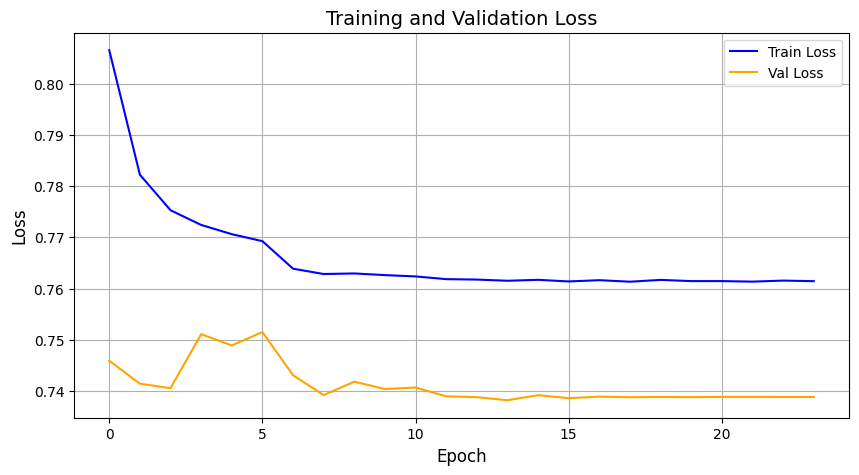

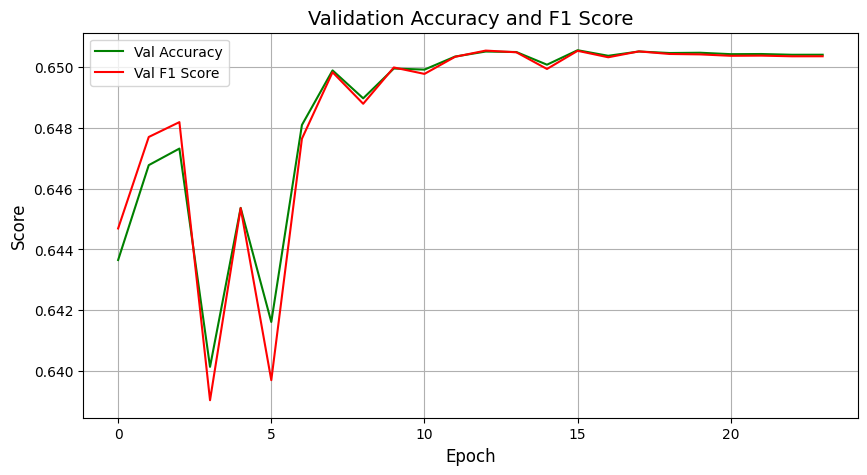

Sao chép best_model.pth vào Kaggle dataset: /kaggle/working/saved_models/best_model.pth
Huấn luyện hoàn tất.


In [14]:
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, f1_score
# import os

# def train_model(model, train_loader, val_loader, num_epochs=50, patience=5, save_path='/kaggle/working/best_model.pth'):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#     #Giảm patience của ReduceLROnPlateau từ 3 xuống 2 để giảm learning rate nhanh hơn
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

#     best_val_loss = float('inf')
#     patience_counter = 0
#     history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

#     # Thư mục lưu dataset bền vững
#     dataset_save_dir = '/kaggle/working/saved_models'
#     os.makedirs(dataset_save_dir, exist_ok=True)
#     dataset_save_path = os.path.join(dataset_save_dir, 'best_model.pth')
    
#     for epoch in range(num_epochs):
#         # Training
#         model.train()
#         train_loss = 0
#         for batch_idx, (features, time_features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
#             features, time_features, labels = features.to(device), time_features.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(features, time_features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         train_loss /= len(train_loader)
#         history['train_loss'].append(train_loss)

#         # Validation
#         model.eval()
#         val_loss = 0
#         val_preds, val_true = [], []
#         with torch.no_grad():
#             for features, time_features, labels in val_loader:
#                 features, time_features, labels = features.to(device), time_features.to(device), labels.to(device)
#                 outputs = model(features, time_features)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 preds = torch.argmax(outputs, dim=1).cpu().numpy()
#                 val_preds.extend(preds)
#                 val_true.extend(labels.cpu().numpy())

#         val_loss /= len(val_loader)
#         val_acc = accuracy_score(val_true, val_preds)
#         val_f1 = f1_score(val_true, val_preds, average='weighted')
#         history['val_loss'].append(val_loss)
#         history['val_acc'].append(val_acc)
#         history['val_f1'].append(val_f1)

#         print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

#         # Lưu model tốt nhất
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(model.state_dict(), save_path)
#             print(f"Saved best model to {save_path}")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"Early stopping at epoch {epoch+1}")
#                 break

#         # Scheduler step
#         scheduler.step(val_loss)
#     # Sau khi huấn luyện, sao chép file vào dataset
#     print(f"Sao chép best_model.pth vào Kaggle dataset: {dataset_save_path}")
    
#     return history

# # Huấn luyện
# NUM_EPOCHS = 40
# PATIENCE = 10
# SAVE_PATH = '/kaggle/working/best_model.pth'

# print("\n--- Bắt đầu huấn luyện ---")
# history = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, patience=PATIENCE, save_path=SAVE_PATH)
# print("Huấn luyện hoàn tất.")

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import psutil

def train_model(model, train_loader, val_loader, num_epochs=50, patience=5, save_path='/kaggle/working/best_model.pth'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

    # Thư mục lưu dataset bền vững
    dataset_save_dir = '/kaggle/working/saved_models'
    os.makedirs(dataset_save_dir, exist_ok=True)
    dataset_save_path = os.path.join(dataset_save_dir, 'best_model.pth')

    for epoch in range(num_epochs):
        # Kiểm tra RAM usage
        print(f"Epoch {epoch+1} - RAM usage: {psutil.virtual_memory().percent}%")
        if torch.cuda.is_available():
            print(f"VRAM usage: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

        # Training
        model.train()
        train_loss = 0
        for batch_idx, (features, time_features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            features, time_features, labels = features.to(device), time_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features, time_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_true = [], []
        with torch.no_grad():
            for features, time_features, labels in val_loader:
                features, time_features, labels = features.to(device), time_features.to(device), labels.to(device)
                outputs = model(features, time_features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_f1 = f1_score(val_true, val_preds, average='weighted')
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Lưu model tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model to {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Scheduler step
        scheduler.step(val_loss)

    # Vẽ đồ thị
    print("Vẽ đồ thị huấn luyện...")
    # Đồ thị 1: Train Loss và Val Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Val Loss', color='orange')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig('/kaggle/working/loss_curve.png')
    plt.show()

    # Đồ thị 2: Val Accuracy và Val F1
    plt.figure(figsize=(10, 5))
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.plot(history['val_f1'], label='Val F1 Score', color='red')
    plt.title('Validation Accuracy and F1 Score', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig('/kaggle/working/metrics_curve.png')
    plt.show()

    # Sao chép best_model.pth vào dataset
    print(f"Sao chép best_model.pth vào Kaggle dataset: {dataset_save_path}")

    return history

# Cập nhật batch size và huấn luyện
BATCH_SIZE = 512  # Giảm từ 256 để tránh tràn RAM
NUM_EPOCHS = 40
PATIENCE = 10
SAVE_PATH = '/kaggle/working/best_model.pth'

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print("\n--- Bắt đầu huấn luyện ---")
history = train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, patience=PATIENCE, save_path=SAVE_PATH)
print("Huấn luyện hoàn tất.")

# Phần 10: Đánh giá và Dự đoán
**Mục tiêu:**

Đánh giá mô hình trên tập test.

Tạo hàm để dự đoán trên dữ liệu mới..


--- Tải model tốt nhất ---

--- Đánh giá trên Validation ---


Đánh giá trên Validation:   0%|          | 0/955 [00:00<?, ?it/s]


Classification Report (Validation):
              precision    recall  f1-score   support

         BUY       0.68      0.69      0.69    287779
        SELL       0.68      0.66      0.67    271547
        HOLD       0.61      0.62      0.62    417716

    accuracy                           0.65    977042
   macro avg       0.66      0.66      0.66    977042
weighted avg       0.65      0.65      0.65    977042



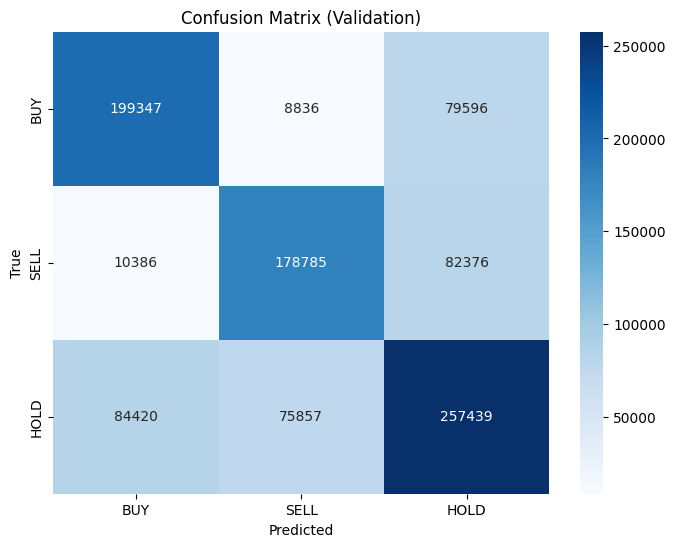


--- Đánh giá trên Test ---


Đánh giá trên Test:   0%|          | 0/955 [00:00<?, ?it/s]


Classification Report (Test):
              precision    recall  f1-score   support

         BUY       0.65      0.71      0.68    268926
        SELL       0.66      0.69      0.67    257889
        HOLD       0.66      0.61      0.63    450229

    accuracy                           0.66    977044
   macro avg       0.66      0.67      0.66    977044
weighted avg       0.66      0.66      0.66    977044



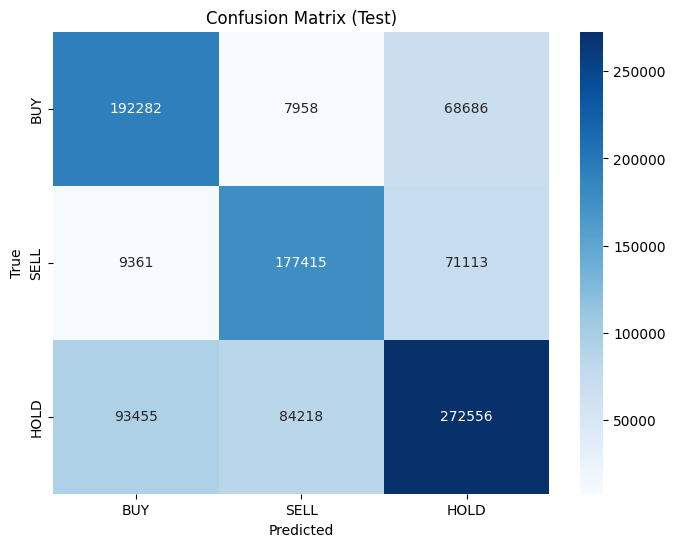

Dự đoán:   0%|          | 0/955 [00:00<?, ?it/s]


Dự đoán trên Test (mẫu đầu tiên): [2, 2, 2, 2, 2]


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader, dataset_name="Test"):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for features, time_features, labels in tqdm(loader, desc=f"Đánh giá trên {dataset_name}"):
            features, time_features, labels = features.to(device), time_features.to(device), labels.to(device)
            outputs = model(features, time_features)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            true.extend(labels.cpu().numpy())

    # Classification Report
    print(f"\nClassification Report ({dataset_name}):")
    print(classification_report(true, preds, target_names=['BUY', 'SELL', 'HOLD']))

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BUY', 'SELL', 'HOLD'], yticklabels=['BUY', 'SELL', 'HOLD'])
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'/kaggle/working/confusion_matrix_{dataset_name.lower()}.png')
    plt.show()

    return preds, true

# Tải model tốt nhất
print("\n--- Tải model tốt nhất ---")
# SAVE_PATH = '/kaggle/input/best-model2-pth/best_model.pth'
SAVE_PATH ='/kaggle/working/best_model.pth'
model.load_state_dict(torch.load(SAVE_PATH))
model.to(device)

# Đánh giá trên tập validation và test
print("\n--- Đánh giá trên Validation ---")
val_preds, val_true = evaluate_model(model, val_loader, "Validation")

print("\n--- Đánh giá trên Test ---")
test_preds, test_true = evaluate_model(model, test_loader, "Test")

# Hàm dự đoán trên dữ liệu mới
def predict_new_data(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for features, time_features, _ in tqdm(data_loader, desc="Dự đoán"):
            features, time_features = features.to(device), time_features.to(device)
            outputs = model(features, time_features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
    return predictions

# Ví dụ dự đoán trên test
test_predictions = predict_new_data(model, test_loader)
print("\nDự đoán trên Test (mẫu đầu tiên):", test_predictions[:5])

# Phần 11: Dự đoán mua
**Mục tiêu:**


In [19]:
# Tải model để sử dụng sau này
def load_model(model, path='/kaggle/input/best-model-pth/best_model.pth'):
    model.load_state_dict(torch.load(path))
    model.to(device)
    model.eval()
    print(f"Đã tải model từ {path}")
    return model

# Ví dụ tải và dự đoán
model = load_model(model, SAVE_PATH)
test_predictions = predict_new_data(model, test_loader)
print("Dự đoán sau khi tải model:", test_predictions[:200])

Đã tải model từ /kaggle/working/best_model.pth


Dự đoán:   0%|          | 0/955 [00:00<?, ?it/s]

Dự đoán sau khi tải model: [2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2]


# Backtesting


--- Chạy Backtesting ---
Số dư cuối kỳ: $-11283620.91
Số giao dịch: 564686
Tỷ lệ thắng: 0.07%
Drawdown tối đa: 112936.21%
Sharpe Ratio: -684.09


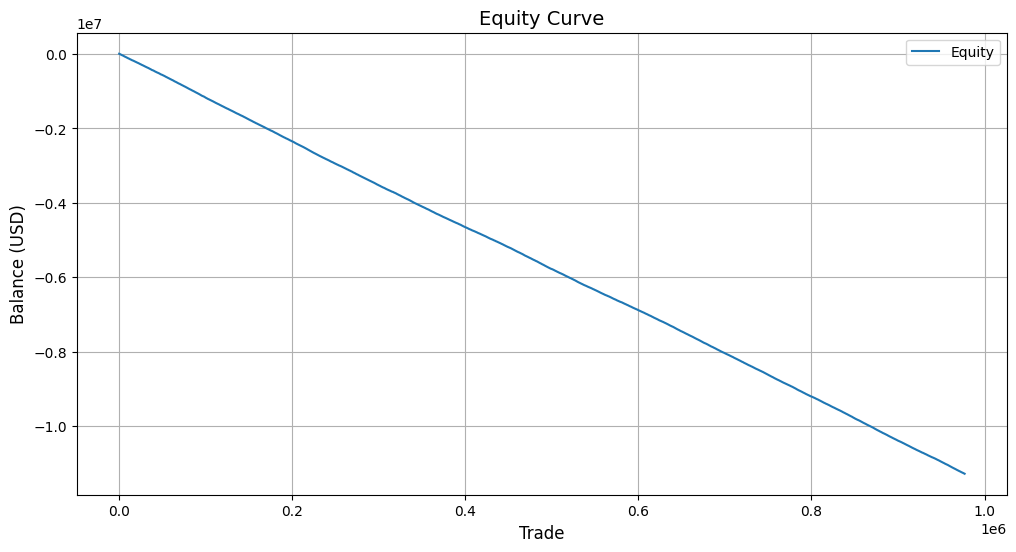

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def backtest(predictions, test_df, initial_balance=10000, lot_size=1.0, spread=0.2, holding_period=30):
    """
    Mô phỏng giao dịch dựa trên dự đoán BUY, SELL, HOLD.
    
    Parameters:
    - predictions: Danh sách dự đoán (0: BUY, 1: SELL, 2: HOLD)
    - test_df: DataFrame chứa dữ liệu test với các cột timestamp, Close
    - initial_balance: Vốn ban đầu (USD)
    - lot_size: Kích thước lot (1 lot = 100 ounce vàng)
    - spread: Chi phí spread mỗi giao dịch (USD/lot)
    - holding_period: Số nến giữ vị thế (phút)
    
    Returns:
    - results: Dictionary chứa số dư cuối kỳ, lịch sử số dư, và các chỉ số
    """
    balance = initial_balance
    equity = initial_balance
    position = 0  # 0: no position, 1: long, -1: short
    entry_price = 0
    trades = []
    equity_history = [initial_balance]
    trade_count = 0
    win_count = 0
    peak_equity = initial_balance
    max_drawdown = 0
    
    # Lặp qua các dự đoán và dữ liệu
    for i, (pred, row) in enumerate(zip(predictions, test_df.itertuples())):
        price = row.Close
        timestamp = row.timestamp
        
        # Đóng vị thế nếu đã giữ đủ holding_period hoặc có tín hiệu ngược
        if position != 0 and i >= holding_period:
            exit_price = price
            profit = 0
            if position == 1:  # Long
                profit = (exit_price - entry_price - spread) * lot_size * 100
            elif position == -1:  # Short
                profit = (entry_price - exit_price - spread) * lot_size * 100
            balance += profit
            equity = balance
            equity_history.append(equity)
            
            # Cập nhật drawdown
            peak_equity = max(peak_equity, equity)
            drawdown = (peak_equity - equity) / peak_equity * 100
            max_drawdown = max(max_drawdown, drawdown)
            
            # Ghi lại giao dịch
            trades.append({
                'entry_time': entry_time,
                'exit_time': timestamp,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'position': 'Long' if position == 1 else 'Short',
                'profit': profit
            })
            trade_count += 1
            if profit > 0:
                win_count += 1
            position = 0
        
        # Mở vị thế mới dựa trên dự đoán
        if position == 0:
            if pred == 0:  # BUY
                position = 1
                entry_price = price
                entry_time = timestamp
            elif pred == 1:  # SELL
                position = -1
                entry_price = price
                entry_time = timestamp
            # HOLD: không làm gì
        
        # Cập nhật số dư nếu không có giao dịch
        if position == 0:
            equity_history.append(equity)
    
    # Đóng vị thế cuối cùng nếu còn
    if position != 0:
        exit_price = test_df.iloc[-1].Close
        profit = 0
        if position == 1:
            profit = (exit_price - entry_price - spread) * lot_size * 100
        elif position == -1:
            profit = (entry_price - exit_price - spread) * lot_size * 100
        balance += profit
        equity = balance
        equity_history.append(equity)
        
        peak_equity = max(peak_equity, equity)
        drawdown = (peak_equity - equity) / peak_equity * 100
        max_drawdown = max(max_drawdown, drawdown)
        
        trades.append({
            'entry_time': entry_time,
            'exit_time': test_df.iloc[-1].timestamp,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'position': 'Long' if position == 1 else 'Short',
            'profit': profit
        })
        trade_count += 1
        if profit > 0:
            win_count += 1
    
    # Tính toán các chỉ số hiệu suất
    win_rate = win_count / trade_count * 100 if trade_count > 0 else 0
    returns = np.diff(equity_history) / initial_balance
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252 * 1440) if np.std(returns) != 0 else 0
    
    results = {
        'final_balance': balance,
        'equity_history': equity_history,
        'trades': pd.DataFrame(trades),
        'trade_count': trade_count,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }
    
    return results

# Chạy backtesting
print("\n--- Chạy Backtesting ---")
backtest_results = backtest(test_predictions, test_with_ta, 
                           initial_balance=10000, 
                           lot_size=1.0, 
                           spread=0.2, 
                           holding_period=30)

# In kết quả
print(f"Số dư cuối kỳ: ${backtest_results['final_balance']:.2f}")
print(f"Số giao dịch: {backtest_results['trade_count']}")
print(f"Tỷ lệ thắng: {backtest_results['win_rate']:.2f}%")
print(f"Drawdown tối đa: {backtest_results['max_drawdown']:.2f}%")
print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")

# Lưu lịch sử giao dịch
backtest_results['trades'].to_csv('/kaggle/working/trades_history.csv', index=False)

# Vẽ đồ thị equity curve
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['equity_history'], label='Equity', color='#1f77b4')
plt.title('Equity Curve', fontsize=14)
plt.xlabel('Trade', fontsize=12)
plt.ylabel('Balance (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/equity_curve.png')
plt.show()